In [2]:
# This approach was modified from an initial approach by Luedman (GitHub name), 
# where we tried to forecast CRIX volatility
# Load Libraries
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import datetime

from keras.optimizers       import Adam
from keras.models           import Sequential
from keras.layers           import Dense
from keras.layers           import LSTM
from keras.models           import load_model

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Define Hyperparameters
look_back = 5
epochs = 20
nodes = 64

In [3]:
# Set wd
path = 'C:/Users/Cedric/Desktop/Uni/19_FS/Research Seminar/LSTM'
os.chdir(path)

# Load the csv data
data = pd.read_csv('USD_CHF_Day.csv')
data.columns = ['date', 'open', 'high','low','close','AskVol']
data = data.drop_duplicates(subset='close', keep="first")

# Convert the data in a pandas dataframe
USD_MXN = pd.DataFrame(data = data[['date', 'close']])
# USD_MXN['date'] = pd.to_datetime(USD_MXN['date'], format="%d.%m.%Y %H:%M:%S.%f")
USD_MXN = USD_MXN.set_index('date')

# Data Checkup
# USD_MXN.tail(57)


In [4]:
exchange_series = USD_MXN['close'].values
exchange_series = exchange_series.reshape(len(exchange_series),1)
exchange_series = exchange_series.astype('float32')

# Normalize the values to a range from zero to 1
scaler            = MinMaxScaler(feature_range=(0, 1))
exchange_series     = scaler.fit_transform(exchange_series)

# Split the data into a training and test set
# We are using 80 percent of the data as training set and 20% as the test set. 
# train_size  = int(len(exchange_series) * 0.80)
# test_size   = len(exchange_series) - train_size

# Do it manually. 64 corresponds to the size of the test set
train, test = exchange_series[0:len(exchange_series)-64], exchange_series[len(exchange_series)-64:len(exchange_series)]


In [5]:
# Create Data Set
# dataX is the the rolling window of past obeservations 
# dataY becomes the the value that is one day ahead of the rolling window. 
# This is the label/prediction for the past values

def create_dataset(time_series, look_back):
    dataX, dataY = [], []
    
    for i in range(1,len(time_series) - look_back - 1):
        
        x = time_series[i:i + look_back]
        dataX.append(x)
        
        y = time_series[i + look_back + 1]
        dataY.append(y)
           
    return np.array(dataX), np.array(dataY)

In [6]:
#Create the dataset with rolling window for the training set and test set
trainX, trainY  = create_dataset(train, look_back)
testX, testY    = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX  = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX   = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [7]:
#Create the model
#LSTM Neural Network with 128 Nodes and 3 Layers, followed by dense layer that outputs the prediction

model = Sequential()
model.add(LSTM(nodes, return_sequences = True, input_shape=(1, look_back)))
model.add(LSTM(nodes, return_sequences = True))
model.add(LSTM(nodes))
model.add(Dense(1))
optimizer = Adam(lr = 0.0001)
model.compile(loss = 'mean_squared_error', optimizer = optimizer)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
#Train the model, epochs is the number of iterations

model.fit(trainX, trainY, epochs = epochs, batch_size = 1, verbose = 1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
2366/2366 [==============================] - 11s 5ms/step - loss: 0.0224
Epoch 2/20
2366/2366 [==============================] - 10s 4ms/step - loss: 9.0636e-04
Epoch 3/20
2366/2366 [==============================] - 9s 4ms/step - loss: 8.5446e-04
Epoch 4/20
2366/2366 [==============================] - 9s 4ms/step - loss: 8.3404e-04
Epoch 5/20
2366/2366 [==============================] - 9s 4ms/step - loss: 7.8372e-04
Epoch 6/20
2366/2366 [==============================] - 10s 4ms/step - loss: 7.4314e-04
Epoch 7/20
2366/2366 [==============================] - 10s 4ms/step - loss: 7.5129e-04
Epoch 8/20
2366/2366 [==============================] - 9s 4ms/step - loss: 7.2608e-04
Epoch 9/20
2366/2366 [==============================] - 10s 4ms/step - loss: 7.1634e-04
Epoch 10/20
2366/2366 [==============================] - 11s 5ms/step - loss: 7.0940e-04
Epoch 11/20
2366/2366 [==============================] - 8s 3ms/step - loss: 6.

In [9]:
#model.save('Output/Model_LB-'+ str(look_back) + '_EP-'+str(epochs)+'.h5')

In [10]:
#Make predictions 
trainPredict    = model.predict(trainX)
testPredict     = model.predict(testX)

#Inverse the normalization procedure of the data
trainY = np.reshape(trainY,(trainY.shape[0],))
testY  = np.reshape(testY,(testY.shape[0],))

trainPredict    = scaler.inverse_transform(trainPredict)
trainY          = scaler.inverse_transform([trainY])
testPredict     = scaler.inverse_transform(testPredict)
testY           = scaler.inverse_transform([testY])

In [11]:
# Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.6f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.6f RMSE' % (testScore))

Train Score: 0.010913 RMSE
Test Score: 0.005182 RMSE


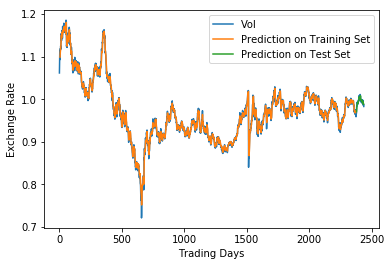

[[0.9707889 ]
 [0.9759325 ]
 [0.9795197 ]
 [0.9820503 ]
 [0.98736006]
 [0.9894652 ]
 [0.9904851 ]
 [0.9918606 ]
 [0.9911277 ]
 [0.991419  ]
 [0.9897929 ]
 [0.9900644 ]
 [0.99261326]
 [0.99365824]
 [0.9948104 ]
 [0.995721  ]
 [0.99539185]
 [0.99750227]
 [0.99730766]
 [0.9992723 ]
 [1.0022701 ]
 [1.0048695 ]
 [1.0035923 ]
 [1.0038977 ]
 [1.0045788 ]
 [1.0031654 ]
 [1.0028609 ]
 [1.0044826 ]
 [1.0048866 ]
 [1.0075988 ]
 [1.007454  ]
 [1.0072963 ]
 [1.0077896 ]
 [1.0008519 ]
 [0.99849504]
 [0.9987152 ]
 [0.99773103]
 [0.99819666]
 [0.9986445 ]
 [0.99844533]
 [0.99805725]
 [0.9979192 ]
 [0.9955011 ]
 [0.9939866 ]
 [0.9924672 ]
 [0.9925673 ]
 [0.99287   ]
 [0.99328655]
 [0.99575675]
 [0.9944076 ]
 [0.9937098 ]
 [0.99454564]
 [0.99108535]
 [0.99310344]
 [0.9900627 ]
 [0.98729515]
 [0.9882456 ]]


In [12]:
#plt.plot(crix_data['vol'].values, color = 'grey')

# Shift train predictions for plotting
trainPredictPlot = np.empty_like(exchange_series)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(exchange_series)
testPredictPlot[:, :]= np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 2:len(exchange_series)-2, :] = testPredict

# Plot baseline and predictions
plt.plot(scaler.inverse_transform(exchange_series), label = 'Vol')
plt.plot(trainPredictPlot, label = 'Prediction on Training Set')
plt.plot(testPredictPlot, label = 'Prediction on Test Set')

plt.legend()
plt.xlabel('Trading Days')
plt.ylabel('Exchange Rate')
# plt.savefig('Output/Plot_LB-'+ str(look_back) + '_EP-'+str(epochs)+'.png', dpi=500)
plt.show()
print(testPredict)
